In [9]:

import os
import pickle
import pandas as pandas
import numpy as np
import graphviz
import pydot
import tensorflow as tf
from tqdm.auto import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


from PIL import Image
from io import BytesIO
import gc
    
import matplotlib.pyplot as plt

In [10]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0']


In [11]:
BASE_DIR = "F:\image captioning\kaggle\input\Flickr8k"
WORKING_DIR = 'F:\image captioning\kaggle\working'



In [12]:
import tensorflow as tf
model30k = tf.keras.models.load_model("F:\image captioning\kaggle\working\model30k.keras")

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model

# Step 1: Select a pre-trained model
base_model = model30k

# Step 2: Remove or modify final layers
base_model.layers.pop()

# Step 3: Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# # Step 4: Add task-specific layers
# x = layers.Flatten()(base_model.output)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# output = layers.Dense(num_classes, activation='softmax')(x)

# # Step 5: Create the new model
# model = Model(inputs=base_model.input, outputs=output)

# # Step 6: Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Step 7: Train the model on your new dataset
# model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))


In [14]:
# # load vgg16 model
# model = model30k(weights='imagenet')
# model.layers.pop()
# # # restructure the model
# # model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# # Step 3: Freeze pre-trained layers
# for layer in base_model.layers:
#     layer.trainable = False

# # Step 4: Add task-specific layers
# x = layers.Flatten()(base_model.output)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# output = layers.Dense(num_classes, activation='softmax')(x)

# # Step 5: Create the new model
# model = Model(inputs=base_model.input, outputs=output)

# # summarize
# print(model.summary())

In [15]:
print(os.getcwd())

F:\image captioning


In [16]:
# # extract features from image
# features = {}
# directory = os.path.join(BASE_DIR, 'Images')

# for img_name in tqdm(os.listdir(directory)):
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature
    
    

In [17]:
# # store features in pickle
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


In [18]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [19]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r',encoding='utf-8') as f:
    next(f)
    captions_doc = f.read()


In [20]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [21]:
len(mapping)


8091

In [22]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption


In [23]:
# # before preprocess of text
# mapping['36979']

In [24]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [25]:
clean(mapping)


In [26]:
# mapping['1000268201_693b08cb0e']

In [27]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [28]:
len(all_captions)

40455

In [29]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [30]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [31]:
vocab_size


8485

In [32]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length = 75

In [33]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [34]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [35]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

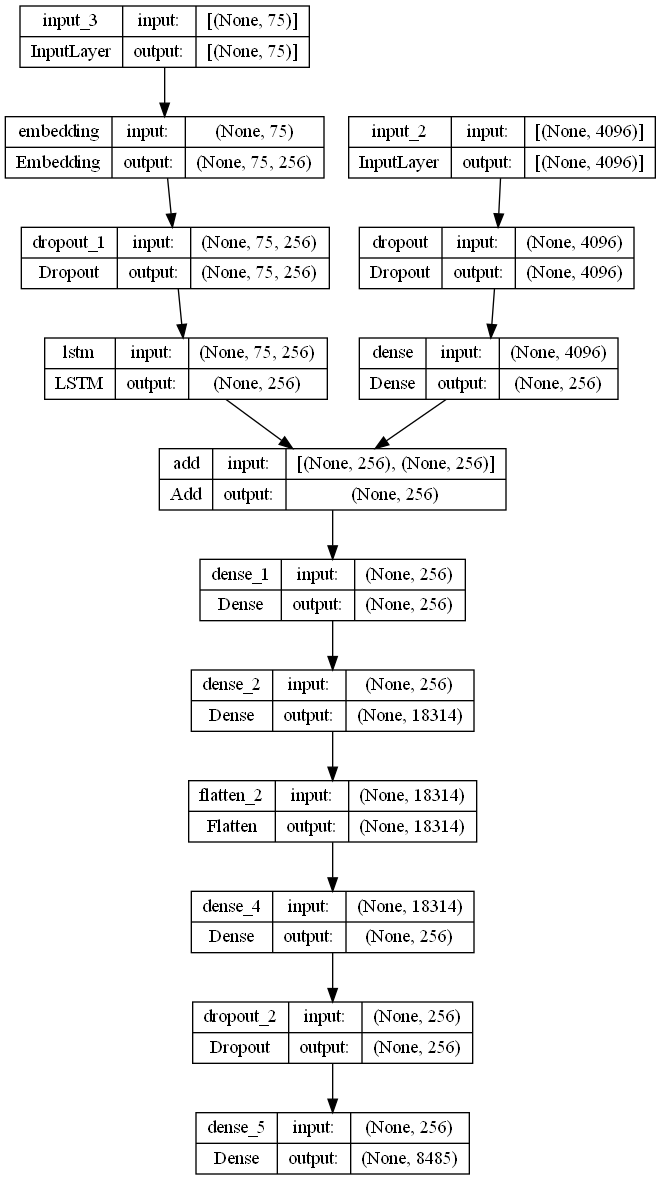

In [38]:
# Step 4: Add task-specific layers
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(vocab_size, activation='softmax')(x)

# Step 5: Create the new model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# plot the model
plot_model(model, show_shapes=True)

In [39]:
# # encoder model
# # image feature layers
# inputs1 = Input(shape=(4096,))
# fe1 = Dropout(0.4)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)
# # sequence feature layers
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)

# # decoder model
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# # plot the model
# plot_model(model, show_shapes=True)

In [41]:
# train the model
epochs = 20
batch_size = 24

steps = len(train) // batch_size
epoch_list = []
accuracy_list = []

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    tf.keras.backend.clear_session
    gc.collect()



    # Append epoch number and accuracy to the lists
    epoch_list.append(i + 1)
    accuracy_list.append(history.history['accuracy'][0])
    
    # Clear session and garbage collection to release memory
    tf.keras.backend.clear_session()
    gc.collect()

# Plotting the epochs vs accuracy graph
plt.plot(epoch_list, accuracy_list, marker='o', linestyle='-', color='b')
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

  9/303 [..............................] - ETA: 10:28 - loss: 9.0366 - accuracy: 0.0786

KeyboardInterrupt: 

In [ ]:
print(accuracy_list)
print(epoch_list)

In [42]:

# save the model
model.save(WORKING_DIR+'/modelcompile4.h5')
model.save(WORKING_DIR+'/modelcompile4.keras')

C:\Users\SATYANKAR\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [44]:
# # save the model
# model.save(WORKING_DIR+'/model30k.h5')

In [45]:
import tensorflow as tf
model = tf.keras.models.load_model("F:\image captioning\kaggle\working\modelcompile.h5")

In [46]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [47]:
# from nltk.translate.bleu_score import corpus_bleu
# # validate with test data
# actual, predicted = list(), list()

# for key in tqdm(test):
#     # get actual caption
#     captions = mapping[key]
#     # predict the caption for image
#     y_pred = predict_caption(model, features[key], tokenizer, max_length) 
#     # split into words
#     actual_captions = [caption.split() for caption in captions]
#     y_pred = y_pred.split()
#     # append to the list
#     actual.append(actual_captions)
#     predicted.append(y_pred)
    
# # calcuate BLEU score
# print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [48]:
tf.keras.backend.clear_session
gc.collect()

16429

In [49]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]

    y_pred = predict_caption(model, features[key], tokenizer, max_length) 

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
bleu1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(actual, predicted, weights=(0.33,0.33,0.33, 0))
bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

print("BLEU-1: %f" % bleu1)
print("BLEU-2: %f" % bleu2)
print("BLEU-3: %f" % bleu3)
print("BLEU-4: %f" % bleu4)

  2%|█▎                                                                               | 13/810 [00:14<14:58,  1.13s/it]


KeyboardInterrupt: 

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption("36979.jpg")

In [76]:

generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq endseq
startseq startseq little girl is sitting in front of large painted rainbow endseq endseq
startseq startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq endseq
startseq startseq there is girl with pigtails sitting in front of rainbow painting endseq endseq
startseq startseq young girl with pigtails painting outside in the grass endseq endseq


KeyError: '1002674143_1b742ab4b8'

In [77]:

generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq startseq man in hat is displaying pictures next to skier in blue hat endseq endseq
startseq startseq man skis past another man displaying paintings in the snow endseq endseq
startseq startseq person wearing skis looking at framed pictures set up in the snow endseq endseq
startseq startseq skier looks at framed pictures in the snow next to trees endseq endseq
startseq startseq man on skis looking at artwork for sale in the snow endseq endseq


KeyError: '101669240_b2d3e7f17b'

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing in the grass endseq


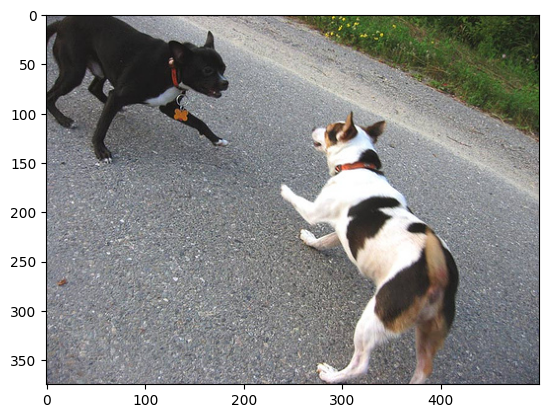

In [81]:

generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq boy with toy gun endseq
startseq little boy in orange shorts playing with toy endseq
startseq young boy with his foot outstretched aims toy at the camera in front of fireplace endseq
startseq young child plays with his new light-up toy endseq
startseq boy with toy gun pointed at the camera endseq
--------------------Predicted--------------------
startseq young girl in the camera endseq


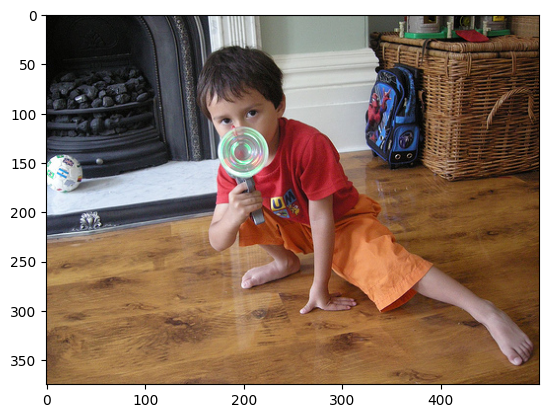

In [82]:
generate_caption("1096395242_fc69f0ae5a.jpg")

---------------------Actual---------------------
startseq girl in tank top and jean capris stands on railroad tracks endseq
startseq girl is standing barefoot on the railroad tracks endseq
startseq girl stands in the train tracks endseq
startseq young woman in jeans and tank top standing on railroad tracks endseq
startseq girl is standing out on the train tracks endseq
--------------------Predicted--------------------
startseq two people are playing in the air endseq


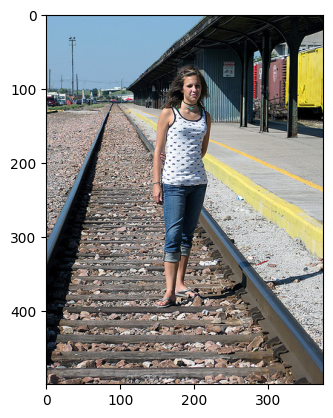

In [83]:
generate_caption("1303550623_cb43ac044a.jpg")

---------------------Actual---------------------
startseq "a baby with pink hat held by man in red and woman in pink ." endseq
startseq man is holding his baby while woman takes picture of the baby endseq
startseq woman takes photo of baby being held by man endseq
startseq woman takes picture of baby wearing pink hat while man carries her endseq
startseq woman is taking picture of baby in pink hat endseq
--------------------Predicted--------------------
startseq two girls in front of white shirt endseq


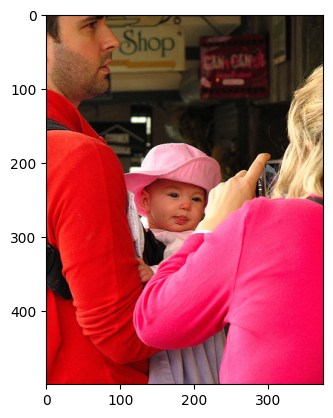

In [84]:
generate_caption("1881494074_1bebd93089.jpg")

---------------------Actual---------------------
startseq the three children are holding umbrellas and watching the ceremony in the rain endseq
startseq three children with colorful umbrellas stand in the rain endseq
startseq three girls holding umbrellas with their backs to the camera endseq
startseq three girls stand under umbrellas before stage endseq
startseq three girls take cover under their umbrellas endseq
--------------------Predicted--------------------
startseq man in red shirt endseq


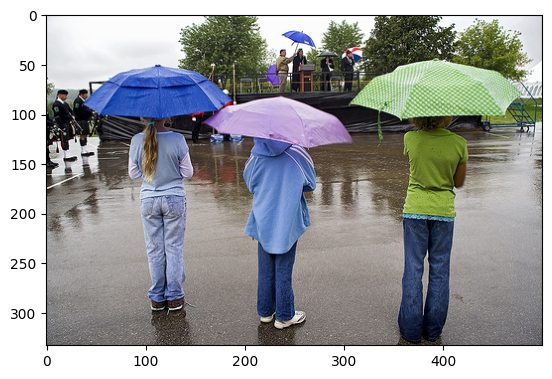

In [85]:
generate_caption("241031670_e60f59b8e4.jpg")

---------------------Actual---------------------
startseq motorcycle races endseq
startseq motorcycle rider in white helmet leans into curve on rural road endseq
startseq motorcycle rider making turn endseq
startseq someone on motorcycle leaning into turn endseq
startseq there is professional motorcyclist turning corner endseq
--------------------Predicted--------------------
startseq man in the air endseq


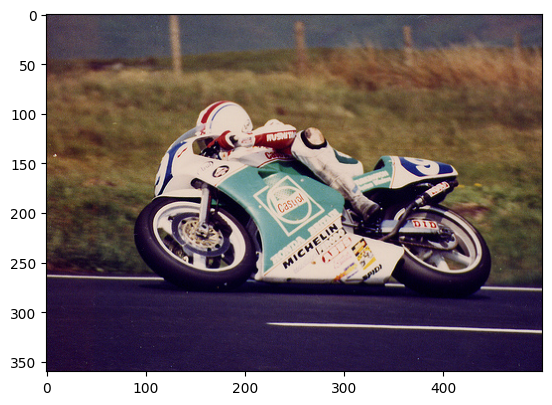

In [86]:
generate_caption("2554531876_5d7f193992.jpg")

---------------------Actual---------------------
startseq group of cyclers race around track endseq
startseq group of people in colored outfits ride bikes around track endseq
startseq bicyclists stay in line as each wear different color suits endseq
startseq multiple bicyclists wearing different colored shirts and helmets riding around track endseq
startseq ten cyclists in different colors are racing around bend in the track endseq
--------------------Predicted--------------------
startseq group of people are playing soccer endseq


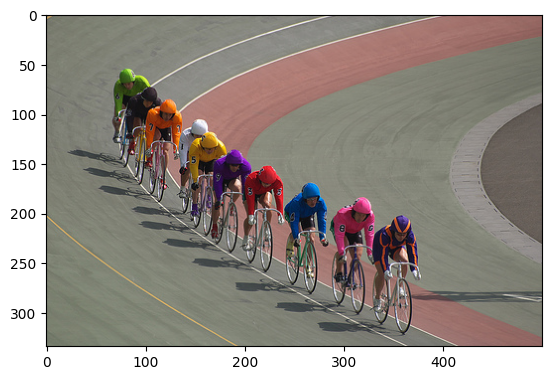

In [87]:
generate_caption("3441145615_b4fcd9eea0.jpg")

---------------------Actual---------------------
startseq "a bull stands in field next to red car ." endseq
startseq red car is parked next to black bull in grassy field endseq
startseq red car parked next to cow in field endseq
startseq large black animal is as large as small red car endseq
startseq there is small red car with black bull standing beside it in the middle of field endseq
--------------------Predicted--------------------
startseq two dogs are playing in the air dirt endseq


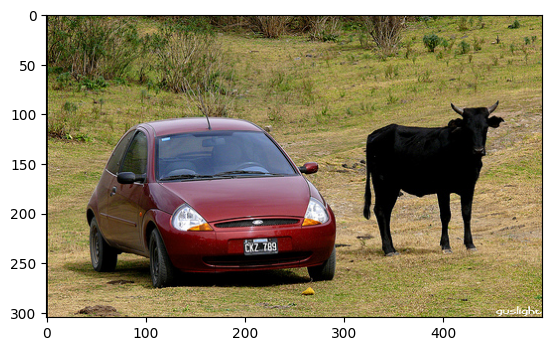

In [88]:
generate_caption("791338571_7f38510bf7.jpg")

In [73]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [74]:
image_path = 'F:\image captioning\kaggle\input\Flickr8k\Images\Formalphoto.jpeg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in the air endseq'

In [75]:
image_path = 'F:\image captioning\kaggle\input\Flickr8k\Images\Satya1.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in the background endseq'

In [76]:
image_path = 'F:\image captioning\kaggle\input\Flickr8k\Images\Satya.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq young boy is in the kitchen endseq'

In [77]:
image_path = 'F:\image captioning\kaggle\input\Flickr8k\Images\satya3.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in the background endseq'

# import matplotlib.pyplot as plt

# Assuming you have train_loss, val_loss, train_accuracy, val_accuracy lists
# Visualize Epoch vs. Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs. Loss')
plt.legend()

# Visualize Epoch vs. Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs. Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Assuming you have actual and predicted values for METEOR calculation
# Calculate METEOR score
from nltk.translate import meteor_score

meteor_scores = [meteor_score.single_meteor_score(actual[i], predicted[i]) for i in range(len(actual))]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score: {:.4f}".format(average_meteor_score))

In [49]:
# losses = []
# accuracies = []

# # Train the model and collect training history
# for i in range(epochs):
#     # create data generator
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     # fit for one epoch and get history
#     history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
#     # Append loss and accuracy to the history lists
#     losses.append(history.history['loss'][0])
#     accuracies.append(history.history['accuracy'][0])

#     # ... (any other code you want to execute after each epoch)

# # Save the model
# model.save(WORKING_DIR+'/best_model.h5')

# # Plotting epoch vs. loss
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, epochs + 1), losses, marker='o', color='b', label='Training Loss')
# plt.title('Epoch vs. Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# # Plotting epoch vs. accuracy
# plt.subplot(1, 2, 2)
# plt.plot(range(1, epochs + 1), accuracies, marker='o', color='r', label='Training Accuracy')
# plt.title('Epoch vs. Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()